# TD 3: Audit de modèles



In this TD the aim is to analyse the decision made by a model.
You will use 3 different methods:
- feature importances with LIME
- black box auditing that consider the features by couple
- counter factual examples with dice-ml

## Installation of the environnement

We highly recommend you to follow these steps, it will allow every student to work in an environment as similar as possible to the one used during testing.

### Colab Settings
  The next cell of code are to execute only once per colab environment


#### Python env creation

        ```
        ! python -m pip install numpy fairlearn plotly nbformat ipykernel aif360["inFairness"] aif360['AdversarialDebiasing'] causal-learn BlackBoxAuditing cvxpy dice-ml lime shapkit
        ```
### Local Settings

#### 1. Uv installation


        https://docs.astral.sh/uv/getting-started/installation/


        `curl -LsSf https://astral.sh/uv/install.sh | sh`

        Python version 3.12 installation (highly recommended)
        `uv python install 3.12`


#### 3. Python env creation

        ```
        mkdir TD_bias_mitigation
        cd TD_bias_mitigation
        uv python pin 3.12
        uv init
        uv pip install numpy fairlearn plotly nbformat ipykernel aif360["inFairness"] aif360['AdversarialDebiasing'] causal-learn BlackBoxAuditing cvxpy dice-ml lime shapkit
        ```


## Import and load the dataset

In [1]:
# imports
import numpy as np
import pandas as pd
import plotly.express as px
import warnings
import matplotlib.pyplot as plt


warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", append=True, category=UserWarning)
# Datasets
from aif360.datasets import MEPSDataset19

# Fairness metrics
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler

MEPSDataset19_data = MEPSDataset19()
(dataset_orig_panel19_train, dataset_orig_panel19_val, dataset_orig_panel19_test) = (
    MEPSDataset19().split([0.5, 0.8], shuffle=True)
)

In [2]:
len(dataset_orig_panel19_train.instance_weights), len(
    dataset_orig_panel19_val.instance_weights
), len(dataset_orig_panel19_test.instance_weights)

(7915, 4749, 3166)

In [3]:
from aif360.sklearn.metrics import *
from sklearn.metrics import  balanced_accuracy_score

 
# This method takes lists
def get_metrics(
    y_true, # list or np.array of truth values
    y_pred=None,  # list or np.array of predictions
    prot_attr=None, # list or np.array of protected/sensitive attribute values
    priv_group=1, # value taken by the privileged group
    pos_label=1, # value taken by the positive truth/prediction
    sample_weight=None # list or np.array of weights value,
):
    group_metrics = {}
    group_metrics["base_rate_truth"] = base_rate(
        y_true=y_true, pos_label=pos_label, sample_weight=sample_weight
    )
    group_metrics["statistical_parity_difference"] = statistical_parity_difference(
        y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, priv_group=priv_group, pos_label=pos_label, sample_weight=sample_weight
    )
    group_metrics["disparate_impact_ratio"] = disparate_impact_ratio(
        y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, priv_group=priv_group, pos_label=pos_label, sample_weight=sample_weight
    )
    if not y_pred is None:
        group_metrics["base_rate_preds"] = base_rate(
        y_true=y_pred, pos_label=pos_label, sample_weight=sample_weight
        )
        group_metrics["equal_opportunity_difference"] = equal_opportunity_difference(
            y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, priv_group=priv_group, pos_label=pos_label, sample_weight=sample_weight
        )
        group_metrics["average_odds_difference"] = average_odds_difference(
            y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, priv_group=priv_group, pos_label=pos_label, sample_weight=sample_weight
        )
        if len(set(y_pred))>1:
            group_metrics["conditional_demographic_disparity"] = conditional_demographic_disparity(
                y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, pos_label=pos_label, sample_weight=sample_weight
            )
        else:
            group_metrics["conditional_demographic_disparity"] =None
        group_metrics["smoothed_edf"] = smoothed_edf(
        y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, pos_label=pos_label, sample_weight=sample_weight
        )
        group_metrics["df_bias_amplification"] = df_bias_amplification(
        y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, pos_label=pos_label, sample_weight=sample_weight
        )
        group_metrics["balanced_accuracy_score"] = balanced_accuracy_score(
        y_true=y_true, y_pred=y_pred, sample_weight=sample_weight
        )
    return group_metrics

2025-12-15 22:45:20.506284: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Utilisation de LIME
### Question 1.1 - apprendre une regression logistique qui prédit l'UTILIZATION (comme dans le TD3)

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

X_train = dataset_orig_panel19_train.features
y_train = dataset_orig_panel19_train.labels[:,0]
X_val = dataset_orig_panel19_val.features
y_val = dataset_orig_panel19_val.labels[:,0]


model = make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear', random_state=42))

model = model.fit(
    X_train,
    y_train,
    **{"logisticregression__sample_weight": dataset_orig_panel19_train.instance_weights}
)

preds = model.predict_proba(X_val)

model.score(X_val, y_val, sample_weight=dataset_orig_panel19_val.instance_weights)

0.8410721622574545

In [5]:
dataset_orig_panel19_train.protected_attribute_names

['RACE']

In [6]:
preds.shape

(4749, 2)

### Question 1.2 (optionelle) - Observer l'impact du threshold sur les performances de la regression logistique (balanced accuracy et disparate impact)

In [7]:
thresh_arr = np.linspace(0.01, 0.5, 50)
metrics_list=[]
for thr in thresh_arr:
    y_val_pred = (preds[:, -1] > thr).astype(np.float64)
    metrics = get_metrics(y_true=dataset_orig_panel19_val.labels[:,0], y_pred=y_val_pred, prot_attr=dataset_orig_panel19_val.protected_attributes[:,0], sample_weight=dataset_orig_panel19_val.instance_weights)
    metrics['threshold'] = thr
    metrics_list.append(metrics)
df_metrics = pd.DataFrame.from_records(metrics_list)

In [8]:
fig = px.parallel_coordinates(
    df_metrics, 
    color="balanced_accuracy_score", 
    dimensions=['threshold', 'disparate_impact_ratio','df_bias_amplification', 'balanced_accuracy_score'])
fig.show()

In [9]:
fig = px.scatter(df_metrics, x='balanced_accuracy_score', y='disparate_impact_ratio', color='threshold', hover_data=["threshold"])
fig.show()

### Question 1.3 : apprendre un LimeEncoder (nomer l'objet lime_data) sur le dataset AIF360 de train, puis transformer avec ce LimeEncoder le dataset de train et celui de test en s_train et s_test

In [10]:
from aif360.datasets.lime_encoder import LimeEncoder

In [11]:

lime_data = LimeEncoder().fit(dataset_orig_panel19_train)

In [12]:
s_train = lime_data.transform(dataset_orig_panel19_train.features)
s_test = lime_data.transform(dataset_orig_panel19_test.features)

### Question 1.4 use LimeTabularExplainer to explain the decision made on several instances of the test dataset.


In [13]:
from lime.lime_tabular import LimeTabularExplainer

In [14]:
explainer = LimeTabularExplainer(
        s_train, 
        class_names=lime_data.s_class_names, 
        feature_names=lime_data.s_feature_names,
        categorical_features=lime_data.s_categorical_features, 
        categorical_names=lime_data.s_categorical_names, 
        kernel_width=3, verbose=False, discretize_continuous=True)

In [15]:
def s_predict_fn(x):
    return model.predict_proba(lime_data.inverse_transform(x))

In [16]:
def show_explanation(ind):
    exp = explainer.explain_instance(s_test[ind], s_predict_fn, num_features=10)
    print("Actual label: " + str(dataset_orig_panel19_test.labels[ind]))
    exp.as_pyplot_figure()
    plt.show()

Actual label: [0.]


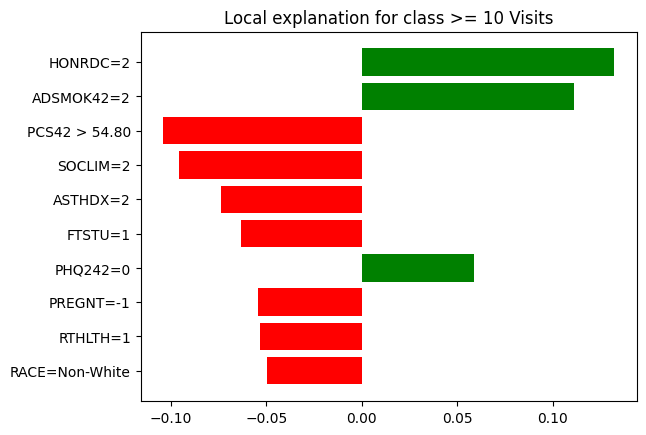

Actual label: [0.]


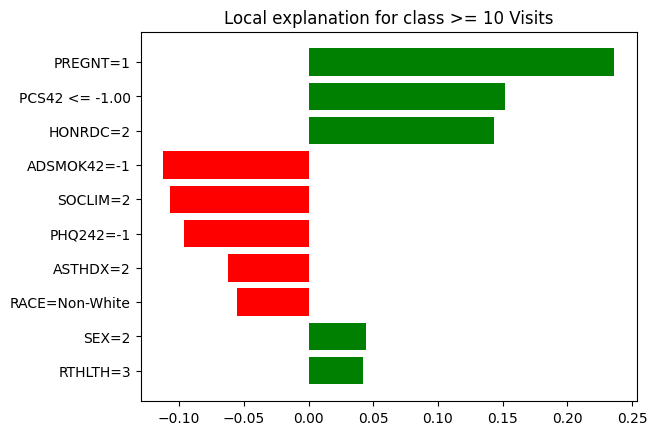

Actual label: [0.]


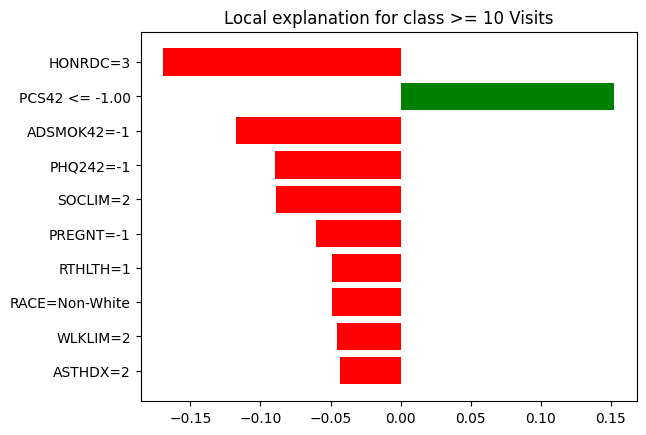

Actual label: [0.]


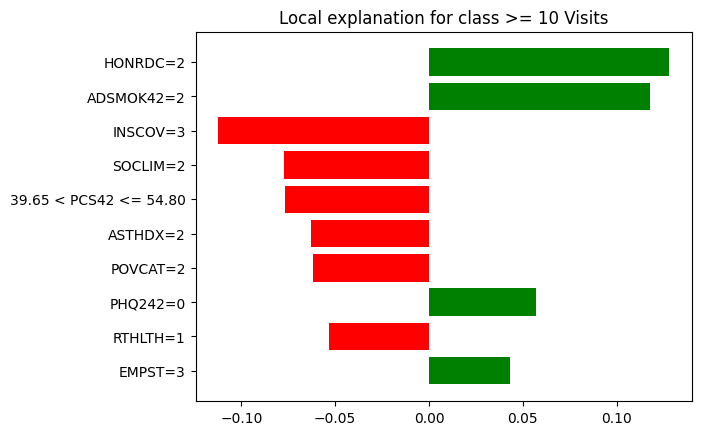

Actual label: [0.]


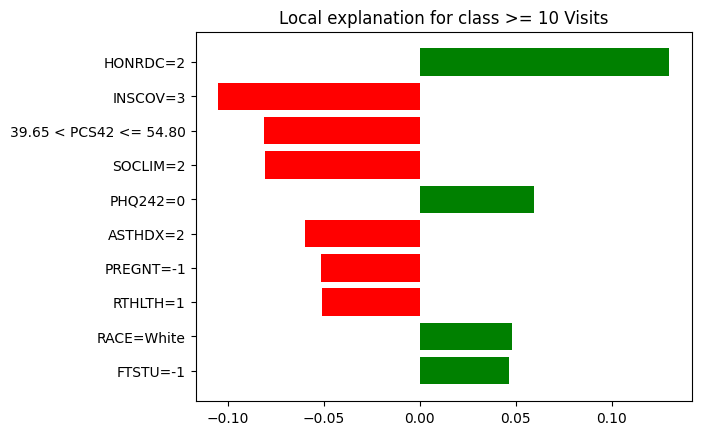

In [17]:
show_explanation(0)
show_explanation(1)
show_explanation(2)
show_explanation(3)
show_explanation(4)

### Question 1.5: Redo the with a regression logistic trained on the Rewieghted dataset

In [18]:
from aif360.algorithms.preprocessing import Reweighing

RW = Reweighing(
    unprivileged_groups=[{'RACE': 0.0}], privileged_groups=[{'RACE': 1.0}]
)
RW.fit(dataset_orig_panel19_train)
dataset_rw_train = RW.transform(dataset_orig_panel19_train)
dataset_rw_val = RW.transform(dataset_orig_panel19_val)
dataset_rw_test = RW.transform(dataset_orig_panel19_test)

In [19]:
model_rw = make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear', random_state=42))

model_rw = model.fit(
    dataset_rw_train.features,
    dataset_rw_train.labels[:,0],
    **{"logisticregression__sample_weight": dataset_rw_train.instance_weights}
)

preds_rw = model_rw.predict_proba(dataset_rw_val.features)

model_rw.score(dataset_rw_val.features, dataset_rw_val.labels[:,0], sample_weight=dataset_rw_val.instance_weights)

0.8327872380920331

In [20]:
thresh_arr = np.linspace(0.01, 0.5, 50)
metrics_list=[]
for thr in thresh_arr:
    y_val_pred = (preds_rw[:, -1] > thr).astype(np.float64)
    metrics = get_metrics(y_true=dataset_rw_val.labels[:,0], y_pred=y_val_pred, prot_attr=dataset_rw_val.protected_attributes[:,0], sample_weight=dataset_rw_val.instance_weights)
    metrics['threshold'] = thr
    metrics_list.append(metrics)
df_metrics = pd.DataFrame.from_records(metrics_list)

In [21]:
fig = px.scatter(df_metrics, x='balanced_accuracy_score', y='disparate_impact_ratio', color='threshold', hover_data=["threshold"])
fig.show()

In [22]:
lime_data_rw = LimeEncoder().fit(dataset_rw_train)
s_train_rw = lime_data_rw.transform(dataset_rw_train.features)
s_test_rw = lime_data_rw.transform(dataset_rw_test.features)
explainer_rw = LimeTabularExplainer(
        s_train_rw, class_names=lime_data_rw.s_class_names, 
        feature_names=lime_data_rw.s_feature_names,
        categorical_features=lime_data_rw.s_categorical_features, 
        categorical_names=lime_data_rw.s_categorical_names, 
        kernel_width=3, verbose=False, discretize_continuous=True)
def s_predict_fn_rw(x):
    return model_rw.predict_proba(lime_data_rw.inverse_transform(x))
def show_explanation_rw(ind):
    exp = explainer_rw.explain_instance(s_test_rw[ind], s_predict_fn_rw, num_features=10)
    print("Actual label: " + str(dataset_rw_test.labels[ind]))
    exp.as_pyplot_figure()
    plt.show()

Actual label: [0.]


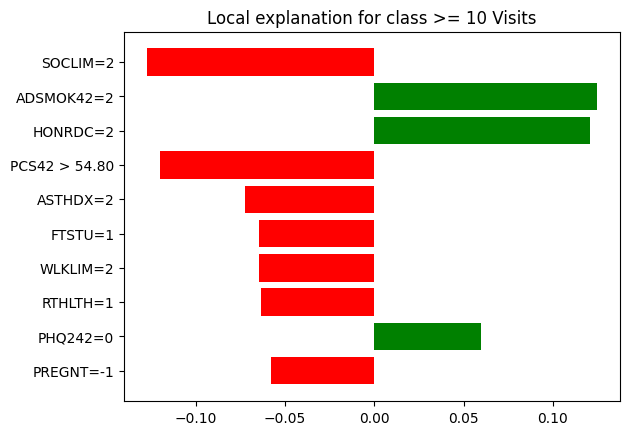

Actual label: [0.]


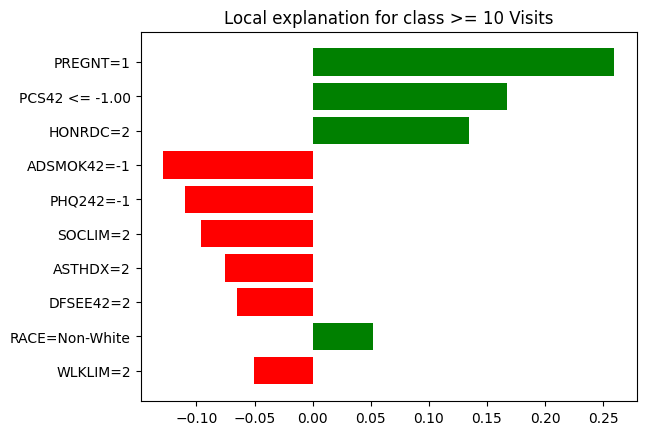

Actual label: [0.]


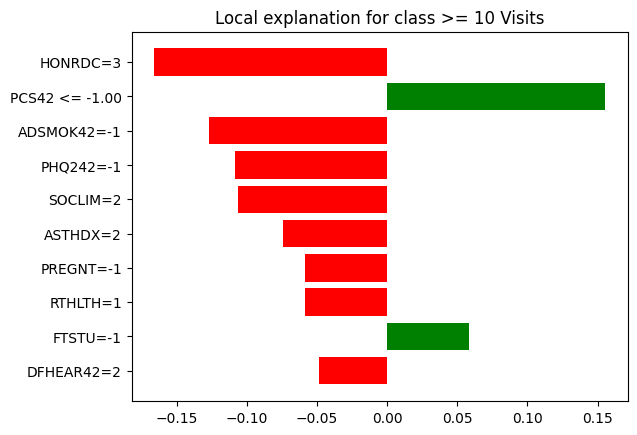

Actual label: [0.]


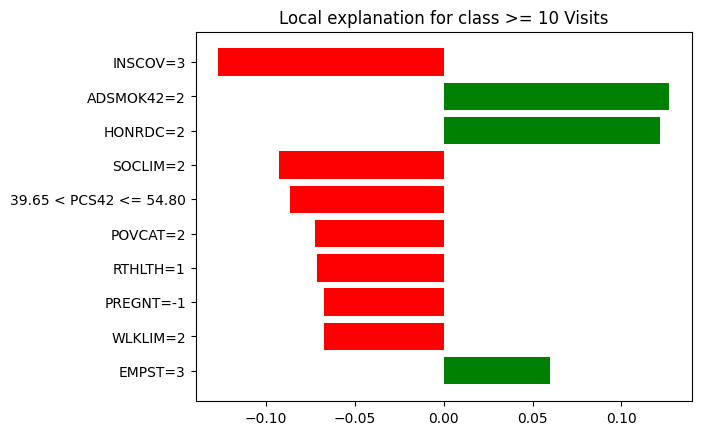

Actual label: [0.]


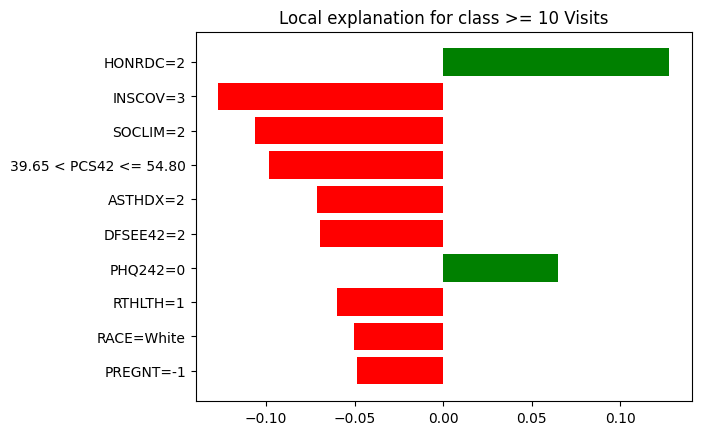

In [23]:
show_explanation(0)
show_explanation(1)
show_explanation(2)
show_explanation(3)
show_explanation(4)

## Question2 Utilisation de BlackBoxAuditing

Attention cette fois, nous nous intéressons aux influences indirectes, cette méthode considères les features par couple.

Aussi transformer les attributs catégoriels en "one hot encoding", n'est cette fois pas une bonne approche car ces colonnes seront par construction très liées entre elles.

Nous allons du coup utiliser un ordinal encoding puis uniquement les classifieurs de sklearn compatible avec les attributs catégoriels ( HistGradientBoostingClassifier).

Il faut dans un premier temps transformer le dataset AIF en dataframe et regrouper les colonnes qui ont déjà été one_hot_encodé (tout cela a déja été fait dans le TD3) puis appliqué un ordinal encoding aux colonnes catégorielles

### Question 2.1 preprocesser la donnée

Afin que vous puissiez passer plus de temps à manipuler les explications, nous vous fournissons le code pour bien formatter le dataframe
vous pouvez passer à la 2.2

In [24]:
from sklearn import preprocessing


def get_df(MepsDataset):
    data = MepsDataset.convert_to_dataframe()
    # data_train est un tuple, avec le data_frame et un dictionnaire avec toutes les infos (poids, attributs sensibles etc)
    df = data[0]
    df["WEIGHT"] = data[1]["instance_weights"]
    # Get categorical column from one hot encoding (specitic to MEPSdataset)
    # Here we create a dictionnary that links each categorical column name
    # to the list of corresponding one hot encoded columns
    categorical_columns_dic = {}
    for col in df.columns:
        col_split = col.split("=")
        if len(col_split) > 1:
            cat_col = col_split[0]
            if not (cat_col in categorical_columns_dic.keys()):
                categorical_columns_dic[cat_col] = []
            categorical_columns_dic[cat_col].append(col)
    categorical_features = categorical_columns_dic.keys()
    print(categorical_features)

    def categorical_transform(df, onehotencoded, cat_col):
        if len(onehotencoded) > 1:
            return df[onehotencoded].apply(
                lambda x: onehotencoded[np.argmax(x)][len(cat_col) + 1 :], axis=1
            )
        else:
            return df[onehotencoded]


    # Reverse the categorical one hot encoded
    for cat_col, onehotencoded in categorical_columns_dic.items():
        df[cat_col] = categorical_transform(df, onehotencoded, cat_col)
        df.drop(columns=onehotencoded, inplace=True)

    encoders = {cat_col:preprocessing.LabelEncoder() for cat_col in categorical_features}

    for cat_col in categorical_features:
        df[cat_col] = encoders[cat_col].fit_transform(df[cat_col])
        print(cat_col)
        for idx in sorted(df[cat_col].unique()):
            print(idx, encoders[cat_col].inverse_transform([idx]))
    return df, encoders


df, encoders = get_df(MEPSDataset19_data)

dict_keys(['REGION', 'SEX', 'MARRY', 'FTSTU', 'ACTDTY', 'HONRDC', 'RTHLTH', 'MNHLTH', 'HIBPDX', 'CHDDX', 'ANGIDX', 'MIDX', 'OHRTDX', 'STRKDX', 'EMPHDX', 'CHBRON', 'CHOLDX', 'CANCERDX', 'DIABDX', 'JTPAIN', 'ARTHDX', 'ARTHTYPE', 'ASTHDX', 'ADHDADDX', 'PREGNT', 'WLKLIM', 'ACTLIM', 'SOCLIM', 'COGLIM', 'DFHEAR42', 'DFSEE42', 'ADSMOK42', 'PHQ242', 'EMPST', 'POVCAT', 'INSCOV'])


REGION
0 ['1']
1 ['2']
2 ['3']
3 ['4']
SEX
0 ['1']
1 ['2']
MARRY
0 ['1']
1 ['10']
2 ['2']
3 ['3']
4 ['4']
5 ['5']
6 ['6']
7 ['7']
8 ['8']
9 ['9']
FTSTU
0 ['-1']
1 ['1']
2 ['2']
3 ['3']
ACTDTY
0 ['1']
1 ['2']
2 ['3']
3 ['4']
HONRDC
0 ['1']
1 ['2']
2 ['3']
3 ['4']
RTHLTH
0 ['-1']
1 ['1']
2 ['2']
3 ['3']
4 ['4']
5 ['5']
MNHLTH
0 ['-1']
1 ['1']
2 ['2']
3 ['3']
4 ['4']
5 ['5']
HIBPDX
0 ['-1']
1 ['1']
2 ['2']
CHDDX
0 ['-1']
1 ['1']
2 ['2']
ANGIDX
0 ['-1']
1 ['1']
2 ['2']
MIDX
0 ['-1']
1 ['1']
2 ['2']
OHRTDX
0 ['-1']
1 ['1']
2 ['2']
STRKDX
0 ['-1']
1 ['1']
2 ['2']
EMPHDX
0 ['-1']
1 ['1']
2 ['2']
CHBRON
0 ['-1']
1 ['1']
2 ['2']
CHOLDX
0 ['-1']
1 ['1']
2 ['2']
CANCERDX
0 ['-1']
1 ['1']
2 ['2']
DIABDX
0 ['-1']
1 ['1']
2 ['2']
JTPAIN
0 ['-1']
1 ['1']
2 ['2']
ARTHDX
0 ['-1']
1 ['1']
2 ['2']
ARTHTYPE
0 ['-1']
1 ['1']
2 ['2']
3 ['3']
ASTHDX
0 ['1']
1 ['2']
ADHDADDX
0 ['-1']
1 ['1']
2 ['2']
PREGNT
0 ['-1']
1 ['1']
2 ['2']
WLKLIM
0 ['-1']
1 ['1']
2 ['2']
ACTLIM
0 ['-1']
1 ['1']
2 ['2']
SOCLIM
0 ['-1']

In [25]:
df

,AGE,RACE,PCS42,MCS42,K6SUM42,UTILIZATION,WEIGHT,REGION,SEX,MARRY,...,ACTLIM,SOCLIM,COGLIM,DFHEAR42,DFSEE42,ADSMOK42,PHQ242,EMPST,POVCAT,INSCOV
0,53.0,1.0,25.93,58.47,3.0,1.0,21854.981705,1,0,5,...,1,2,2,2,2,2,1,4,0,1
1,56.0,1.0,20.42,26.57,17.0,1.0,18169.604822,1,1,3,...,1,2,2,2,2,2,7,4,2,1
3,23.0,1.0,53.12,50.33,7.0,0.0,17191.832515,1,1,5,...,2,2,2,2,2,2,1,1,1,1
4,3.0,1.0,-1.00,-1.00,-1.0,0.0,20261.485463,1,0,6,...,0,2,0,2,2,0,0,0,1,1
5,27.0,0.0,-1.00,-1.00,-1.0,0.0,0.000000,2,0,0,...,2,2,2,2,2,0,0,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16573,25.0,0.0,56.71,62.39,0.0,0.0,4111.315754,2,0,0,...,2,2,2,2,2,2,1,1,0,0
16574,25.0,0.0,56.71,62.39,0.0,0.0,5415.228173,2,1,0,...,2,2,2,2,2,2,1,4,0,0
16575,2.0,1.0,-1.00,-1.00,-1.0,0.0,3896.116219,2,1,6,...,0,2,0,2,2,0,0,0,0,1
16576,54.0,0.0,43.97,42.45,24.0,0.0,4883.851005,0,1,3,...,2,2,2,2,2,2,1,1,2,1


### Question 2.2  Separation train/test du dataframe transformé pour BlackBoxAudit

In [26]:
label = "UTILIZATION"
df_X = df[[col for col in df.columns if col!=label]]
df_X

,AGE,RACE,PCS42,MCS42,K6SUM42,WEIGHT,REGION,SEX,MARRY,FTSTU,...,ACTLIM,SOCLIM,COGLIM,DFHEAR42,DFSEE42,ADSMOK42,PHQ242,EMPST,POVCAT,INSCOV
0,53.0,1.0,25.93,58.47,3.0,21854.981705,1,0,5,0,...,1,2,2,2,2,2,1,4,0,1
1,56.0,1.0,20.42,26.57,17.0,18169.604822,1,1,3,0,...,1,2,2,2,2,2,7,4,2,1
3,23.0,1.0,53.12,50.33,7.0,17191.832515,1,1,5,3,...,2,2,2,2,2,2,1,1,1,1
4,3.0,1.0,-1.00,-1.00,-1.0,20261.485463,1,0,6,0,...,0,2,0,2,2,0,0,0,1,1
5,27.0,0.0,-1.00,-1.00,-1.0,0.000000,2,0,0,0,...,2,2,2,2,2,0,0,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16573,25.0,0.0,56.71,62.39,0.0,4111.315754,2,0,0,0,...,2,2,2,2,2,2,1,1,0,0
16574,25.0,0.0,56.71,62.39,0.0,5415.228173,2,1,0,0,...,2,2,2,2,2,2,1,4,0,0
16575,2.0,1.0,-1.00,-1.00,-1.0,3896.116219,2,1,6,0,...,0,2,0,2,2,0,0,0,0,1
16576,54.0,0.0,43.97,42.45,24.0,4883.851005,0,1,3,0,...,2,2,2,2,2,2,1,1,2,1


In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_X, df[label], test_size=0.33, random_state=42)

### Question 2.3: Apprentissage d'un modèle HistGradientBoostingClassifier

In [28]:
from sklearn import ensemble
cat_mask = np.array([ col_name in encoders.keys() for col_name in df_X.columns])
clf = ensemble.HistGradientBoostingClassifier(random_state=42, categorical_features=cat_mask)
clf = clf.fit(X_train, y_train)

preds = clf.predict(X_test)

clf.score(X_test, y_test), clf.score(X_train, y_train)

(0.858728943338438, 0.9137280784461626)

### Question 2.4 utiliser la librairie BlackBoxAuditing pour "auditer" le modèle par l'analyse des influences indirectes de l'age (le calcul prend du temps mais n'hesitez pas à faires d'autres attributs)

Le code est de nouveau fournit, vous avez juste à adapter avec vos notations

Voici la documentaiton de la librairie utilisée
https://github.com/algofairness/BlackBoxAuditing/tree/master

In [29]:
import pickle

# Save your data and model (named clf here) on disk

data_test = X_test.copy(deep=True)
data_test["Y"] = y_test

data_test.to_csv("TD5_test_data.csv",
          index=False)

data_train = X_train.copy(deep=True)
data_train["Y"] = y_train

data_train.to_csv("TD5_train_data.csv",
          index=False)

with open( 'TD5_clf.pickle', 'wb' ) as f:
    pickle.dump(clf, f )

In [30]:
from BlackBoxAuditing.data import load_from_file
from BlackBoxAuditing.model_factories.AbstractModelFactory import AbstractModelFactory
from BlackBoxAuditing.model_factories.AbstractModelVisitor import AbstractModelVisitor

import BlackBoxAuditing as BBA


(_, train_BBA, _, _, _, _) = load_from_file("TD5_train_data.csv",
                      correct_types = [int if col_type=="int" else float for col_type in  data_train.dtypes],
                                response_header = 'Y',
                               train_percentage = 1.0)
(headers, _, test_BBA, response_header, features_to_ignore, correct_types) = load_from_file("TD5_test_data.csv",
                      correct_types = [int if col_type=="int" else float for col_type in  data_test.dtypes],
                                response_header = 'Y',
                               train_percentage = 0.0)
BBA_data = (headers, train_BBA, test_BBA, response_header, features_to_ignore, correct_types)

In [31]:
class HirePredictorBuilder(AbstractModelFactory):
    def __init__(self, *args, **kwargs):
        AbstractModelFactory.__init__(self, *args, **kwargs)
        self.verbose_factory_name = "HirePredictor"
    def build(self, train_set):
        return HirePredictor()

class HirePredictor(AbstractModelVisitor):
    def __init__(self):
        with open( 'TD5_clf.pickle', 'rb' ) as f:
            self.clf = pickle.load(f)

    def test(self, test_set, test_name=""):
        return [[v[-1], self.clf.predict(np.expand_dims(np.array(v[:-1]), axis = 0))] for v in test_set]


In [32]:
features_to_audit = [
    "AGE",
    "SEX",
    "RACE",
    "REGION"
    ]

In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

auditor = BBA.Auditor()
auditor.ModelFactory = HirePredictorBuilder
auditor(BBA_data, output_dir = "audit-output", features_to_audit=features_to_audit)

Training initial model. (22:46:11)
Calculating original model statistics on test data:
	Training Set:
		Conf-Matrix: {0.0: {0.0: 8619, 1.0: 165}, 1.0: {0.0: 750, 1.0: 1072}}
		accuracy: 0.9137280784461626
		BCR: 0.7847901408408462
	Testing Set:
		Conf-Matrix {0.0: {0.0: 4104, 1.0: 224}, 1.0: {1.0: 382, 0.0: 514}}
		accuracy: 0.858728943338438
		BCR: 0.6872916391602852
Auditing: 'AGE' (1/4). (22:48:51)
Auditing: 'SEX' (2/4). (22:58:23)
Auditing: 'RACE' (3/4). (23:08:06)


### Question 2.5: If you are curious redo the auditing of a model with bias mitigation approach (for example Reweighing)

## Question 3: Generer des exemples contrefactuels en utilisant dice-ml

Voici la documentation de la librairie utilisée
https://github.com/interpretml/DiCE?tab=readme-ov-file


In [ ]:
import dice_ml
from dice_ml.utils import helpers

In [ ]:
# provide the trained ML model to DiCE's model object
# use the HistGradientBoostingClassifier from the BlackBoxAuditiing
backend = 'sklearn'
m = dice_ml.Model(model=clf, backend=backend)

### Question 3.1 : Create a list with all continuous features

In [ ]:
df.columns

Index(['AGE', 'RACE', 'PCS42', 'MCS42', 'K6SUM42', 'UTILIZATION', 'WEIGHT',
       'REGION', 'SEX', 'MARRY', 'FTSTU', 'ACTDTY', 'HONRDC', 'RTHLTH',
       'MNHLTH', 'HIBPDX', 'CHDDX', 'ANGIDX', 'MIDX', 'OHRTDX', 'STRKDX',
       'EMPHDX', 'CHBRON', 'CHOLDX', 'CANCERDX', 'DIABDX', 'JTPAIN', 'ARTHDX',
       'ARTHTYPE', 'ASTHDX', 'ADHDADDX', 'PREGNT', 'WLKLIM', 'ACTLIM',
       'SOCLIM', 'COGLIM', 'DFHEAR42', 'DFSEE42', 'ADSMOK42', 'PHQ242',
       'EMPST', 'POVCAT', 'INSCOV'],
      dtype='object')

In [ ]:
numerical_features = list(set(df.columns)-set(encoders.keys()))
numerical_features


['UTILIZATION', 'RACE', 'PCS42', 'AGE', 'WEIGHT', 'MCS42', 'K6SUM42']

In [ ]:
numerical_features.remove("RACE")

In [ ]:
continuous_features = [col for col in numerical_features if col!=label]
data_train.columns, continuous_features

(Index(['AGE', 'RACE', 'PCS42', 'MCS42', 'K6SUM42', 'WEIGHT', 'REGION', 'SEX',
        'MARRY', 'FTSTU', 'ACTDTY', 'HONRDC', 'RTHLTH', 'MNHLTH', 'HIBPDX',
        'CHDDX', 'ANGIDX', 'MIDX', 'OHRTDX', 'STRKDX', 'EMPHDX', 'CHBRON',
        'CHOLDX', 'CANCERDX', 'DIABDX', 'JTPAIN', 'ARTHDX', 'ARTHTYPE',
        'ASTHDX', 'ADHDADDX', 'PREGNT', 'WLKLIM', 'ACTLIM', 'SOCLIM', 'COGLIM',
        'DFHEAR42', 'DFSEE42', 'ADSMOK42', 'PHQ242', 'EMPST', 'POVCAT',
        'INSCOV', 'Y'],
       dtype='object'),
 ['PCS42', 'AGE', 'WEIGHT', 'MCS42', 'K6SUM42'])

### Question 3.2 ceate a dice_ml Data with the dataframe.

In [ ]:
d = dice_ml.Data(dataframe=data_train,continuous_features=continuous_features,outcome_name='Y')

In [ ]:
# DiCE explanation instance
exp = dice_ml.Dice(d,m, method="random")

### Question 3.3  use dice to create counterfactual example using the 'random' method

In [ ]:
# Generate counterfactual examples
query_instance = data_test.drop(columns="Y")[0:10]
dice_exp = exp.generate_counterfactuals(
    query_instance,
    total_CFs=1,
    desired_class="opposite")#, sparsity_weight=0.1)
# Visualize counterfactual explanation

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:40,  4.52s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec


 20%|██        | 2/10 [00:08<00:35,  4.45s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec


 30%|███       | 3/10 [00:13<00:30,  4.42s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec


 50%|█████     | 5/10 [00:18<00:17,  3.44s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec


 60%|██████    | 6/10 [00:22<00:15,  3.79s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec


 90%|█████████ | 9/10 [00:29<00:02,  2.96s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec


100%|██████████| 10/10 [00:33<00:00,  3.39s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec


In [ ]:
dice_exp.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 0.0)


,AGE,RACE,PCS42,MCS42,K6SUM42,WEIGHT,REGION,SEX,MARRY,FTSTU,...,SOCLIM,COGLIM,DFHEAR42,DFSEE42,ADSMOK42,PHQ242,EMPST,POVCAT,INSCOV,Y
0,5.0,1.0,-1.0,-1.0,-1.0,13610.238281,2,1,6,0,...,2,0,2,2,0,0,0,0,0,0.0



No counterfactuals found!
Query instance (original outcome : 0.0)


,AGE,RACE,PCS42,MCS42,K6SUM42,WEIGHT,REGION,SEX,MARRY,FTSTU,...,SOCLIM,COGLIM,DFHEAR42,DFSEE42,ADSMOK42,PHQ242,EMPST,POVCAT,INSCOV,Y
0,0.0,1.0,-1.0,-1.0,-1.0,9913.623047,1,1,6,0,...,2,0,0,0,0,0,0,3,1,0.0



No counterfactuals found!
Query instance (original outcome : 0.0)


,AGE,RACE,PCS42,MCS42,K6SUM42,WEIGHT,REGION,SEX,MARRY,FTSTU,...,SOCLIM,COGLIM,DFHEAR42,DFSEE42,ADSMOK42,PHQ242,EMPST,POVCAT,INSCOV,Y
0,9.0,0.0,-1.0,-1.0,-1.0,0.0,2,1,6,0,...,2,0,2,2,0,0,0,2,1,0.0



No counterfactuals found!
Query instance (original outcome : 1.0)


,AGE,RACE,PCS42,MCS42,K6SUM42,WEIGHT,REGION,SEX,MARRY,FTSTU,...,SOCLIM,COGLIM,DFHEAR42,DFSEE42,ADSMOK42,PHQ242,EMPST,POVCAT,INSCOV,Y
0,66.0,0.0,36.130001,57.73,1.0,3124.025146,2,0,0,0,...,2,2,2,2,2,1,4,3,0,1.0



Diverse Counterfactual set (new outcome: 0.0)


,AGE,RACE,PCS42,MCS42,K6SUM42,WEIGHT,REGION,SEX,MARRY,FTSTU,...,SOCLIM,COGLIM,DFHEAR42,DFSEE42,ADSMOK42,PHQ242,EMPST,POVCAT,INSCOV,Y
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,0.0


Query instance (original outcome : 0.0)


,AGE,RACE,PCS42,MCS42,K6SUM42,WEIGHT,REGION,SEX,MARRY,FTSTU,...,SOCLIM,COGLIM,DFHEAR42,DFSEE42,ADSMOK42,PHQ242,EMPST,POVCAT,INSCOV,Y
0,30.0,1.0,57.490002,54.200001,2.0,9047.264648,1,0,0,0,...,2,2,2,2,2,1,1,3,0,0.0



No counterfactuals found!
Query instance (original outcome : 0.0)


,AGE,RACE,PCS42,MCS42,K6SUM42,WEIGHT,REGION,SEX,MARRY,FTSTU,...,SOCLIM,COGLIM,DFHEAR42,DFSEE42,ADSMOK42,PHQ242,EMPST,POVCAT,INSCOV,Y
0,11.0,0.0,-1.0,-1.0,-1.0,2064.312744,2,0,6,0,...,2,0,2,2,0,0,0,2,2,0.0



No counterfactuals found!
Query instance (original outcome : 0.0)


,AGE,RACE,PCS42,MCS42,K6SUM42,WEIGHT,REGION,SEX,MARRY,FTSTU,...,SOCLIM,COGLIM,DFHEAR42,DFSEE42,ADSMOK42,PHQ242,EMPST,POVCAT,INSCOV,Y
0,23.0,0.0,41.639999,53.259998,0.0,4692.54248,0,1,5,3,...,2,2,2,2,2,1,1,2,2,0.0



Diverse Counterfactual set (new outcome: 1.0)


,AGE,RACE,PCS42,MCS42,K6SUM42,WEIGHT,REGION,SEX,MARRY,FTSTU,...,SOCLIM,COGLIM,DFHEAR42,DFSEE42,ADSMOK42,PHQ242,EMPST,POVCAT,INSCOV,Y
0,80.6,1.0,-,-,17.7,60075.7,-,-,-,-,...,-,-,-,0.0,-,-,-,-,-,1.0


Query instance (original outcome : 0.0)


,AGE,RACE,PCS42,MCS42,K6SUM42,WEIGHT,REGION,SEX,MARRY,FTSTU,...,SOCLIM,COGLIM,DFHEAR42,DFSEE42,ADSMOK42,PHQ242,EMPST,POVCAT,INSCOV,Y
0,35.0,1.0,55.93,46.330002,2.0,15466.445312,2,1,0,0,...,2,2,2,2,2,1,1,4,0,0.0



Diverse Counterfactual set (new outcome: 1.0)


,AGE,RACE,PCS42,MCS42,K6SUM42,WEIGHT,REGION,SEX,MARRY,FTSTU,...,SOCLIM,COGLIM,DFHEAR42,DFSEE42,ADSMOK42,PHQ242,EMPST,POVCAT,INSCOV,Y
0,-,-,-,-,-,-,-,-,8.0,-,...,-,-,-,-,-,-,-,-,-,1.0


Query instance (original outcome : 0.0)


,AGE,RACE,PCS42,MCS42,K6SUM42,WEIGHT,REGION,SEX,MARRY,FTSTU,...,SOCLIM,COGLIM,DFHEAR42,DFSEE42,ADSMOK42,PHQ242,EMPST,POVCAT,INSCOV,Y
0,25.0,0.0,56.709999,62.389999,0.0,3244.702148,3,1,5,0,...,2,2,2,2,2,1,1,3,0,0.0



No counterfactuals found!
Query instance (original outcome : 0.0)


,AGE,RACE,PCS42,MCS42,K6SUM42,WEIGHT,REGION,SEX,MARRY,FTSTU,...,SOCLIM,COGLIM,DFHEAR42,DFSEE42,ADSMOK42,PHQ242,EMPST,POVCAT,INSCOV,Y
0,6.0,1.0,-1.0,-1.0,-1.0,19452.455078,1,1,6,0,...,2,0,2,2,0,0,0,0,1,0.0



No counterfactuals found!


### Question 3.4 Redo the counterfactuals creation using only data statistics not the data itself

In [ ]:
# Data privacy, provides only stats of the data, not the data itself
features={}    
for c in data_train.columns:
    if c in continuous_features:
        features[c]=[data_train[c].min(), data_train[c].max()]
    elif c=="Y":
        continue
    else:
        features[c]=data_train[c].unique().tolist()
    features[c].sort()

In [ ]:
features

{'AGE': [0.0, 85.0],
 'RACE': [0.0, 1.0],
 'PCS42': [-9.0, 72.07],
 'MCS42': [-9.0, 74.41],
 'K6SUM42': [-9.0, 24.0],
 'WEIGHT': [0.0, 94264.071559],
 'REGION': [0, 1, 2, 3],
 'SEX': [0, 1],
 'MARRY': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'FTSTU': [0, 1, 2, 3],
 'ACTDTY': [0, 1, 2, 3],
 'HONRDC': [0, 1, 2, 3],
 'RTHLTH': [0, 1, 2, 3, 4, 5],
 'MNHLTH': [0, 1, 2, 3, 4, 5],
 'HIBPDX': [0, 1, 2],
 'CHDDX': [0, 1, 2],
 'ANGIDX': [0, 1, 2],
 'MIDX': [0, 1, 2],
 'OHRTDX': [0, 1, 2],
 'STRKDX': [0, 1, 2],
 'EMPHDX': [0, 1, 2],
 'CHBRON': [0, 1, 2],
 'CHOLDX': [0, 1, 2],
 'CANCERDX': [0, 1, 2],
 'DIABDX': [0, 1, 2],
 'JTPAIN': [0, 1, 2],
 'ARTHDX': [0, 1, 2],
 'ARTHTYPE': [0, 1, 2, 3],
 'ASTHDX': [0, 1],
 'ADHDADDX': [0, 1, 2],
 'PREGNT': [0, 1, 2],
 'WLKLIM': [0, 1, 2],
 'ACTLIM': [0, 1, 2],
 'SOCLIM': [0, 1, 2],
 'COGLIM': [0, 1, 2],
 'DFHEAR42': [0, 1, 2],
 'DFSEE42': [0, 1, 2],
 'ADSMOK42': [0, 1, 2],
 'PHQ242': [0, 1, 2, 3, 4, 5, 6, 7],
 'EMPST': [0, 1, 2, 3, 4],
 'POVCAT': [0, 1, 2, 3, 4],
 'I

In [ ]:
d = dice_ml.Data(features=features,
         outcome_name='Y')

In [ ]:
# DiCE explanation instance
exp = dice_ml.Dice(d,m, method="random")

In [ ]:
# Generate counterfactual examples
query_instance = data_test.drop(columns="Y")[0:10]
dice_exp = exp.generate_counterfactuals(
    query_instance,
    total_CFs=1,
    desired_class="opposite")#, sparsity_weight=0.1)
# Visualize counterfactual explanation


100%|██████████| 10/10 [00:01<00:00,  5.65it/s]


In [ ]:
dice_exp.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 0.0)


,AGE,RACE,PCS42,MCS42,K6SUM42,WEIGHT,REGION,SEX,MARRY,FTSTU,...,SOCLIM,COGLIM,DFHEAR42,DFSEE42,ADSMOK42,PHQ242,EMPST,POVCAT,INSCOV,Y
0,5.0,1.0,-1.0,-1.0,-1.0,13610.237816,2,1,6,0,...,2,0,2,2,0,0,0,0,0,0.0



Diverse Counterfactual set without sparsity correction since only metadata about each  feature is available (new outcome: 1.0


,AGE,RACE,PCS42,MCS42,K6SUM42,WEIGHT,REGION,SEX,MARRY,FTSTU,...,SOCLIM,COGLIM,DFHEAR42,DFSEE42,ADSMOK42,PHQ242,EMPST,POVCAT,INSCOV,Y
0,-,-,-,41.0,-,-,-,-,0.0,-,...,-,-,-,-,-,-,-,-,-,1.0


Query instance (original outcome : 0.0)


,AGE,RACE,PCS42,MCS42,K6SUM42,WEIGHT,REGION,SEX,MARRY,FTSTU,...,SOCLIM,COGLIM,DFHEAR42,DFSEE42,ADSMOK42,PHQ242,EMPST,POVCAT,INSCOV,Y
0,0.0,1.0,-1.0,-1.0,-1.0,9913.62353,1,1,6,0,...,2,0,0,0,0,0,0,3,1,0.0



Diverse Counterfactual set without sparsity correction since only metadata about each  feature is available (new outcome: 1.0


,AGE,RACE,PCS42,MCS42,K6SUM42,WEIGHT,REGION,SEX,MARRY,FTSTU,...,SOCLIM,COGLIM,DFHEAR42,DFSEE42,ADSMOK42,PHQ242,EMPST,POVCAT,INSCOV,Y
0,-,-,-,-,-,-,-,0.0,-,-,...,-,-,-,-,-,-,-,-,-,1.0


Query instance (original outcome : 0.0)


,AGE,RACE,PCS42,MCS42,K6SUM42,WEIGHT,REGION,SEX,MARRY,FTSTU,...,SOCLIM,COGLIM,DFHEAR42,DFSEE42,ADSMOK42,PHQ242,EMPST,POVCAT,INSCOV,Y
0,9.0,0.0,-1.0,-1.0,-1.0,0.0,2,1,6,0,...,2,0,2,2,0,0,0,2,1,0.0



Diverse Counterfactual set without sparsity correction since only metadata about each  feature is available (new outcome: 1.0


,AGE,RACE,PCS42,MCS42,K6SUM42,WEIGHT,REGION,SEX,MARRY,FTSTU,...,SOCLIM,COGLIM,DFHEAR42,DFSEE42,ADSMOK42,PHQ242,EMPST,POVCAT,INSCOV,Y
0,-,-,-,-,-,-,-,-,-,-,...,1.0,-,-,-,-,-,-,-,-,1.0


Query instance (original outcome : 1.0)


,AGE,RACE,PCS42,MCS42,K6SUM42,WEIGHT,REGION,SEX,MARRY,FTSTU,...,SOCLIM,COGLIM,DFHEAR42,DFSEE42,ADSMOK42,PHQ242,EMPST,POVCAT,INSCOV,Y
0,66.0,0.0,36.13,57.73,1.0,3124.025098,2,0,0,0,...,2,2,2,2,2,1,4,3,0,1.0



Diverse Counterfactual set without sparsity correction since only metadata about each  feature is available (new outcome: 0.0


,AGE,RACE,PCS42,MCS42,K6SUM42,WEIGHT,REGION,SEX,MARRY,FTSTU,...,SOCLIM,COGLIM,DFHEAR42,DFSEE42,ADSMOK42,PHQ242,EMPST,POVCAT,INSCOV,Y
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,0.0,-,-,-,-,0.0


Query instance (original outcome : 0.0)


,AGE,RACE,PCS42,MCS42,K6SUM42,WEIGHT,REGION,SEX,MARRY,FTSTU,...,SOCLIM,COGLIM,DFHEAR42,DFSEE42,ADSMOK42,PHQ242,EMPST,POVCAT,INSCOV,Y
0,30.0,1.0,57.49,54.2,2.0,9047.264436,1,0,0,0,...,2,2,2,2,2,1,1,3,0,0.0



Diverse Counterfactual set without sparsity correction since only metadata about each  feature is available (new outcome: 1.0


,AGE,RACE,PCS42,MCS42,K6SUM42,WEIGHT,REGION,SEX,MARRY,FTSTU,...,SOCLIM,COGLIM,DFHEAR42,DFSEE42,ADSMOK42,PHQ242,EMPST,POVCAT,INSCOV,Y
0,-,-,19.0,-,-,-,-,-,-,-,...,1.0,-,-,-,-,-,-,-,-,1.0


Query instance (original outcome : 0.0)


,AGE,RACE,PCS42,MCS42,K6SUM42,WEIGHT,REGION,SEX,MARRY,FTSTU,...,SOCLIM,COGLIM,DFHEAR42,DFSEE42,ADSMOK42,PHQ242,EMPST,POVCAT,INSCOV,Y
0,11.0,0.0,-1.0,-1.0,-1.0,2064.312726,2,0,6,0,...,2,0,2,2,0,0,0,2,2,0.0



Diverse Counterfactual set without sparsity correction since only metadata about each  feature is available (new outcome: 1.0


,AGE,RACE,PCS42,MCS42,K6SUM42,WEIGHT,REGION,SEX,MARRY,FTSTU,...,SOCLIM,COGLIM,DFHEAR42,DFSEE42,ADSMOK42,PHQ242,EMPST,POVCAT,INSCOV,Y
0,-,1.0,-,-,-,-,-,-,-,-,...,1.0,-,-,-,-,-,-,-,-,1.0


Query instance (original outcome : 0.0)


,AGE,RACE,PCS42,MCS42,K6SUM42,WEIGHT,REGION,SEX,MARRY,FTSTU,...,SOCLIM,COGLIM,DFHEAR42,DFSEE42,ADSMOK42,PHQ242,EMPST,POVCAT,INSCOV,Y
0,23.0,0.0,41.64,53.26,0.0,4692.542239,0,1,5,3,...,2,2,2,2,2,1,1,2,2,0.0



Diverse Counterfactual set without sparsity correction since only metadata about each  feature is available (new outcome: 1.0


,AGE,RACE,PCS42,MCS42,K6SUM42,WEIGHT,REGION,SEX,MARRY,FTSTU,...,SOCLIM,COGLIM,DFHEAR42,DFSEE42,ADSMOK42,PHQ242,EMPST,POVCAT,INSCOV,Y
0,-,-,-,-,-,-,-,-,0.0,-,...,-,-,-,-,-,-,-,-,1.0,1.0


Query instance (original outcome : 0.0)


,AGE,RACE,PCS42,MCS42,K6SUM42,WEIGHT,REGION,SEX,MARRY,FTSTU,...,SOCLIM,COGLIM,DFHEAR42,DFSEE42,ADSMOK42,PHQ242,EMPST,POVCAT,INSCOV,Y
0,35.0,1.0,55.93,46.33,2.0,15466.445419,2,1,0,0,...,2,2,2,2,2,1,1,4,0,0.0



Diverse Counterfactual set without sparsity correction since only metadata about each  feature is available (new outcome: 1.0


,AGE,RACE,PCS42,MCS42,K6SUM42,WEIGHT,REGION,SEX,MARRY,FTSTU,...,SOCLIM,COGLIM,DFHEAR42,DFSEE42,ADSMOK42,PHQ242,EMPST,POVCAT,INSCOV,Y
0,-,-,-,10.0,-5.0,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,1.0


Query instance (original outcome : 0.0)


,AGE,RACE,PCS42,MCS42,K6SUM42,WEIGHT,REGION,SEX,MARRY,FTSTU,...,SOCLIM,COGLIM,DFHEAR42,DFSEE42,ADSMOK42,PHQ242,EMPST,POVCAT,INSCOV,Y
0,25.0,0.0,56.71,62.39,0.0,3244.702055,3,1,5,0,...,2,2,2,2,2,1,1,3,0,0.0



Diverse Counterfactual set without sparsity correction since only metadata about each  feature is available (new outcome: 1.0


,AGE,RACE,PCS42,MCS42,K6SUM42,WEIGHT,REGION,SEX,MARRY,FTSTU,...,SOCLIM,COGLIM,DFHEAR42,DFSEE42,ADSMOK42,PHQ242,EMPST,POVCAT,INSCOV,Y
0,-,-,-,-,8.0,30896.0,-,-,0.0,-,...,-,1.0,-,-,-,-,-,-,-,1.0


Query instance (original outcome : 0.0)


,AGE,RACE,PCS42,MCS42,K6SUM42,WEIGHT,REGION,SEX,MARRY,FTSTU,...,SOCLIM,COGLIM,DFHEAR42,DFSEE42,ADSMOK42,PHQ242,EMPST,POVCAT,INSCOV,Y
0,6.0,1.0,-1.0,-1.0,-1.0,19452.455901,1,1,6,0,...,2,0,2,2,0,0,0,0,1,0.0



Diverse Counterfactual set without sparsity correction since only metadata about each  feature is available (new outcome: 1.0


,AGE,RACE,PCS42,MCS42,K6SUM42,WEIGHT,REGION,SEX,MARRY,FTSTU,...,SOCLIM,COGLIM,DFHEAR42,DFSEE42,ADSMOK42,PHQ242,EMPST,POVCAT,INSCOV,Y
0,-,-,-,-,-,-,-,-,-,-,...,1.0,-,-,-,-,-,-,1.0,-,1.0


### Question 3.5: If you are curious redo the counter factual example creation with a model with bias mitigation approach (for example Reweighing)